In [ ]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist, squareform

In [ ]:
def sammon_error(X, selected_features):
    """
    Calculate Sammon error (stress) between original data X and low-dimensional data X_low.
    
    Parameters:
    - X: Original data (n_samples, n_features)
    - selected_features: Binari vector representing the selected columns (n_features)
    
    Returns:
    - sammon_error: Sammon error (float)
    """
    # Ensure selected_features is a boolean or binary mask
    selected_features = np.array(selected_features, dtype=bool)
    
    X_low = X[:, selected_features]
    
    # Compute pairwise distances in the original data
    D_orig = pdist(X, metric='euclidean')
    D_orig = squareform(D_orig)  # Convert to a square matrix
    
    # Compute pairwise distances in the low-dimensional data (selected features)
    D_low = pdist(X_low, metric='euclidean')
    D_low = squareform(D_low)
    
    # Avoid division by zero by replacing zeros with a small number
    D_orig[D_orig == 0] = np.finfo(float).eps
    
    # Calculate the Sammon error (Sammon stress)
    delta = D_orig - D_low
    sammon_error = np.sum((delta**2) / D_orig)
    
    # Normalize the error by the sum of original distances
    sammon_error /= np.sum(D_orig)
    
    return sammon_error

In [357]:
class SEUFSEnvironment:
    def __init__(
        self,
        state_size,
        data,
        online=True,
        sparse=False,
        max_features=15,
        error_f=sammon_error,
    ):
        self.state_size = state_size  # Length of the state vector
        self.state = np.zeros(
            self.state_size, dtype=bool
        )  # Initialize state as all False
        self.error_f = error_f
        self.data = data
        self._state_prev_error = None#error_f(data, self.state)
        self.online = online
        self.cur_num_features = 0
        self.max_features = max_features
        self.sparse = sparse

    def get_done(self):
        if self.sparse:
            return self.cur_num_features >= self.max_features

        return np.all(self.state)

    def _get_reward_sparse(self):
        self.cur_num_features = int(np.sum(self.state))
        r = 0
        cur_error = self.error_f(self.data, self.state)
        if self._state_prev_error is not None:
            dif = self._state_prev_error - cur_error
        else:
            dif = 1 - cur_error
        if self.get_done():
            r = 1 - cur_error
        # if dif <= 0:
        #     dif = -1
        r += dif/self.max_features/10
            
        self._state_prev_error = cur_error
        return r

    def _get_reward(self, changed_state=True):
        if self.online:
            cur_error = self.error_f(self.data, self.state)
            if self._state_prev_error is not None:
                dif = self._state_prev_error - cur_error
            else:
                dif = -cur_error
            self._state_prev_error = cur_error
            return dif
        if changed_state:
            return -self.error_f(self.data, self.state)
        else:
            return 0

    def get_reward(self, changed_state=True):
        if self.sparse:
            return self._get_reward_sparse()
        return self._get_reward(changed_state)

    def reset(self):
        """Reset the environment state at the start of each episode."""
        self.state = np.zeros(self.state_size, dtype=bool)
        self._state_prev_error = None#error_f(data, self.state)
        self.cur_num_features = 0
        return self.state

    def step(self, action):
        """
        Perform the chosen action in the environment.

        Args:
            action (int): The index in the state to be set to True.

        Returns:
            state (np.array): Updated state after the action.
            reward (float): Reward for taking the action.
            done (bool): Whether the episode has ended.
            info (dict): Additional info, if any (empty here).
        """
        # Set the state at the action's index to True
        prev_state_at = self.state[action]
        self.state[action] = True

        changed_state = prev_state_at != self.state[action]

        # Reward logic
        reward = self.get_reward(changed_state)

        # Determine if the episode is done (e.g., all states set to True)
        done = self.get_done()
        # if done:
        #     print(done)

        return self.state, reward, done, {}

In [358]:
class NStepSARSA:
    def __init__(self, state_dim, action_dim, n=3, alpha=0.01, gamma=0.99, epsilon=0.1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n = n  # Number of steps
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table for state-action pairs as zeros
        self.q_table = np.zeros((state_dim, action_dim))
        print(self.q_table)

        # Replay buffer for n-step transitions
        self.replay_buffer = []
        
    def select_action(self, state):
        """Epsilon-greedy policy for action selection."""
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            return np.argmax(self.q_table[state])
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))
        
        # Remove oldest transition if buffer size exceeds n
        if len(self.replay_buffer) > self.n:
            self.replay_buffer.pop(0)
    
    def update_q_values(self):
        """Perform n-step SARSA update using stored transitions."""
        if len(self.replay_buffer) < self.n:
            return  # Wait until we have enough steps

        # Calculate n-step return G using rewards and next state-action pair
        G = 0
        done = False
        for i, (_, _, reward, _, done) in enumerate(self.replay_buffer):
            G += (self.gamma ** i) * reward  # Discounted reward sum
            if done:
                break  # Stop summing rewards if episode has terminated

        # Get first state-action pair from the buffer
        state, action, _, _, _ = self.replay_buffer[0]
        
        # If the episode ends within n steps, set next Q-value as zero
        if done:
            td_target = G
        else:
            # If episode continues, include next Q-value estimate
            next_state, next_action, _, _, _ = self.replay_buffer[-1]
            td_target = G + (self.gamma ** self.n) * self.q_table[next_state][next_action]
        
        # SARSA Update: Q(S, A) <- Q(S, A) + alpha * (td_target - Q(S, A))
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error
        
    def train(self, env: SEUFSEnvironment, episodes: int, max_steps: int):
        """Train the agent using n-step SARSA."""
        for episode in range(episodes):
            state = env.reset()  # Reset the environment to the starting state
            action = self.select_action(state)
            self.replay_buffer = []  # Clear the replay buffer for each episode
            
            for step in range(max_steps):
                # Take action, observe reward and next state
                next_state, reward, done, _ = env.step(action)  # Assuming env.step returns (next_state, reward, done, info)
                next_action = self.select_action(next_state)
                
                # Store transition and update Q-values if enough steps are taken
                self.store_transition(state, action, reward, next_state, done)
                self.update_q_values()
                
                # Move to the next state and action
                state, action = next_state, next_action
                
                # Break if episode is done
                if done:
                    break


In [359]:
data_train = pd.read_csv("../data/data_train.csv", sep=',')
data_test = pd.read_csv("../data/data_test.csv", sep=',')
data_train.head()

,repository,LCOM5,WMC,CBO,NOI_c,RFC,CLOC_c,DIT,NOA,NOC,...,TNOS_m,HCPL,HDIF,HEFF,HNDB,HPL,HPV,HTRP,HVOL,MI
0,recommenders-team_recommenders,3.484536,13.948454,0.268041,0.175258,5.865979,47.845361,0.030928,0.030928,0.030928,...,10.424908,17.626091,0.946289,123.713377,0.011553,8.822311,5.909960,6.872965,34.659469,52.708286
1,ansible_ansible,2.460000,11.521935,0.383871,0.249032,3.944516,9.249677,0.267097,0.274839,0.223871,...,8.096763,16.960101,0.821704,140.214293,0.010462,7.453463,5.358586,7.789683,31.384585,43.619663
2,python_mypy,4.745626,20.709287,0.522207,0.554509,8.247645,17.150740,0.803499,0.816958,0.366083,...,5.554887,15.700527,0.851261,123.168731,0.009638,7.055235,5.086295,6.842707,28.915393,25.116836
3,hpcaitech_ColossalAI,3.167149,10.542692,0.329233,0.335745,4.484805,15.290883,0.156295,0.156295,0.138205,...,7.389521,19.964883,1.040007,203.418684,0.014098,9.626516,5.939346,11.301038,42.294285,53.518406
4,httpie_cli,2.305389,5.107784,0.365269,0.221557,3.113772,4.874251,0.257485,0.263473,0.239521,...,4.327044,10.140832,0.789708,36.672611,0.005911,5.623834,4.638342,2.037367,17.734353,49.713385


In [360]:
X_train = data_train.drop(columns=["repository"], inplace=False)
X_train = X_train.to_numpy()
X_train, X_train.shape

(array([[ 3.48453608, 13.94845361,  0.26804124, ...,  6.87296538,
         34.65946915, 52.70828605],
        [ 2.46      , 11.52193548,  0.38387097, ...,  7.78968294,
         31.38458498, 43.61966283],
        [ 4.74562584, 20.70928668,  0.52220727, ...,  6.84270728,
         28.91539346, 25.11683622],
        ...,
        [ 1.53791187,  8.14767765,  0.39976181, ..., 10.55182418,
         41.75895437, 35.24916235],
        [ 3.91798561, 16.0057554 ,  0.63021583, ...,  6.18104476,
         24.76377797, 68.96475529],
        [ 4.25903614, 12.1686747 ,  0.57228916, ...,  8.3908338 ,
         44.03298782, 39.82271873]]),
 (84, 42))

In [361]:
X_test = data_test.drop(columns=["repository"], inplace=False)
X_test = X_test.to_numpy()
X_test, X_test.shape

(array([[2.63470874e+00, 1.10558252e+01, 1.72330097e-01, 1.37135922e-01,
         4.39077670e+00, 1.19490291e+01, 1.16504854e-01, 1.16504854e-01,
         1.09223301e-01, 1.16504854e-01, 1.09223301e-01, 8.04623786e+01,
         6.47111650e+01, 4.48179612e+00, 4.25364078e+00, 3.17439320e+01,
         8.05546117e+01, 6.47864078e+01, 4.56067961e+00, 4.26213592e+00,
         3.17657767e+01, 2.64287786e+00, 4.64461851e-01, 2.40847113e+00,
         1.75398898e+00, 2.43051929e+00, 1.27249782e+01, 1.67977952e+01,
         7.46330142e+00, 1.94313896e+00, 1.29019437e+01, 1.70092834e+01,
         7.58862779e+00, 1.06088154e+01, 6.67731208e-01, 6.62787645e+01,
         6.68143130e-03, 5.55038968e+00, 4.09916689e+00, 3.68215358e+00,
         2.00442939e+01, 5.49371907e+01],
        [2.06217617e+00, 6.85967185e+00, 4.16234888e-01, 3.60967185e-01,
         3.17487047e+00, 1.09611399e+01, 3.68739206e-01, 3.80397237e-01,
         3.02677029e-01, 3.80397237e-01, 3.02677029e-01, 5.41809154e+01,
         

In [362]:
state_space = X_train.shape[1]
action_space = X_train.shape[1]

state_space, action_space

(42, 42)

In [363]:
# Example usage
env = SEUFSEnvironment(state_size=state_space, data=X_train)

state = env.reset()
print("Initial prev error", env._state_prev_error)
print("Initial State:", state)

actions = [0, 2, 4, 1, 3]  # Sequence of actions to take

for action in actions:
    state, reward, done, _ = env.step(action)
    print(f"Action taken: {action}, New State: {state}, Reward: {reward}, Done: {done}")
    if done:
        print("Episode finished!")
        break

Initial prev error None
Initial State: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Action taken: 0, New State: [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False], Reward: -0.9854289273140168, Done: False
Action taken: 2, New State: [ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False], Reward: 0.0005064187704258982, Done: False
Action taken: 4, New State: [ True False  True F

In [364]:
X_train[0, state]

array([ 3.48453608, 13.94845361,  0.26804124,  0.17525773,  5.86597938])

In [365]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import SmoothL1Loss
# from torch.nn import _reduction as _Reduction, functional as F
import numpy as np
import random
from collections import deque

from tqdm import tqdm

In [366]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-values for each action

In [367]:
class SemiGradientNSarsa:
    def __init__(self, state_size, action_size, n_steps=5, alpha=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.n_steps = n_steps
        self.alpha = alpha
        self.gamma = gamma
        self.q_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.memory = []
        self.loss_function = SmoothL1Loss()

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)  # Explore
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.FloatTensor(state))
                return torch.argmax(q_values).item()  # Exploit
    
    def reset_memory(self):
        self.memory = []
    
    def store_transition(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.n_steps:
            self.memory.pop(0)

    def update_q_values(self, done):
        if len(self.memory) == 0:
            return

        # Calculate returns
        states = []
        actions = []
        rewards = []
        next_states = []
        next_actions = []
        for i in range(len(self.memory)):
            state, action, reward, next_state, next_action = self.memory[i]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            next_actions.append(next_action)

        G = 0
        n = self.n_steps# min(len(rewards), self.n_steps)
        for i in range(n):
            G += (self.gamma ** i) * rewards[i]
        if not done:
            next_state = next_states[-1]  # Use the last state to estimate Q
            next_action = next_actions[-1]  # Use the last state to estimate Q
            with torch.no_grad():
                next_q_values = self.q_network(torch.FloatTensor(next_state))
                G += (self.gamma ** n) * next_q_values[next_action].item()

        # Update the Q-values
        state_tensor = torch.FloatTensor(states[0])
        action_tensor = torch.LongTensor([actions[0]])
        target = torch.FloatTensor([G])
        predicted = self.q_network(state_tensor)[action_tensor]

        # loss = F.smooth_l1_loss(predicted, predicted)#(predicted - target) ** 2
        loss = self.loss_function(predicted, target)
        print(loss)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, num_episodes, max_iter=1000, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
        epsilon = epsilon_start
        episode_returns = []
        with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
            for episode in range(num_episodes):
                state = env.reset()
                done = False
                episode_return = 0
                self.reset_memory()
                t = 0
                while not done and t < max_iter:
                    action = self.select_action(state, epsilon)
                    next_state, reward, done, _ = env.step(action)
                    # store SARSA
                    self.store_transition((state, action, reward, next_state, self.select_action(next_state, epsilon)))
                    episode_return += reward
                    
                    if t - self.n_steps + 1 > 0:
                        self.update_q_values(done)
                    if done:
                        break
                    state = next_state
                    t += 1

                # Decay epsilon
                epsilon = max(epsilon_end, epsilon * epsilon_decay)
                # tqdm.write(f"Episode {episode + 1}: Return = {episode_return}")
                pbar.set_postfix(Return=episode_return)
                pbar.update(1)
                episode_returns.append(episode_return)
        return episode_returns


# Example usage (assuming you have an environment):
# state_size = 10  # For example, a binary vector of size 10
# action_size = 5  # Number of possible actions
# env = YourEnvironment()  # Replace with your environment
# agent = SemiGradientNSarsa(state_size, action_size)
# agent.train(env, num_episodes=1000)

In [370]:
# Example usage
state_size = state_space  # Length of the binary vector
action_size = state_space  # Assuming one action for each feature
env = SEUFSEnvironment(state_size=state_size, data=X_train)
agent = SemiGradientNSarsa(state_size, action_size, n_steps=state_size//2)

episode_returns = agent.train(env=env, num_episodes=5000, max_iter=state_space//2)

# Training loop (simplified)
# num_episodes = 1000
# for episode in range(num_episodes):
#     state = np.zeros(state_size, dtype=np.float32)
#     done = False
#     steps = 0
#     while not done:
#         action = agent.select_action(state)
#         next_state = state.copy()
#         next_state[action] = 1  # Setting the index corresponding to action to True
#         reward = 1 if np.all(next_state) else 0  # Reward structure
#         done = reward == 1 or steps > 100  # Episode termination
        
#         agent.store_transition((state, action, reward, next_state, done))
#         agent.train_step()

#         state = next_state
#         steps += 1

Training Episodes: 100%|██████████| 5000/5000 [00:14<00:00, 342.29it/s, Return=-0.898] 


In [371]:
import matplotlib.pyplot as plt

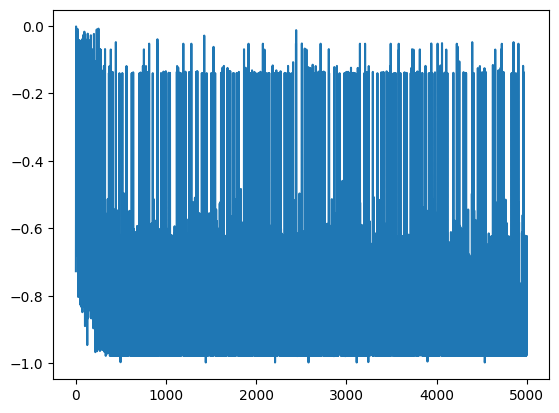

In [372]:
plt.plot(episode_returns)

In [ ]:
# Define the DQN Agent
class DQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        device,
        gamma=0.99,
        lr=0.001,
        batch_size=64,
        buffer_size=10000,
        target_update=10,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.device = device

        # Initialize main and target networks
        self.policy_net = QNetwork(state_size, action_size).to(device)
        self.target_net = QNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Set up optimizer and replay memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)
        self.steps_done = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.choice(range(self.action_size))
        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            return torch.argmax(self.policy_net(state)).item()

    def store_transition(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        return random.sample(self.memory, self.batch_size)

    def update_q_values(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_batch()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Calculate Q(s, a) using policy network
        current_q_values = (
            self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        )

        # Calculate target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss
        loss = nn.functional.mse_loss(current_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network every target_update steps
        if self.steps_done % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(
        self,
        env,
        num_episodes,
        max_iters,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=0.995,
    ):
        epsilon = epsilon_start
        returns = []

        with tqdm(total=num_episodes, desc="Training DQN") as pbar:
            for episode in range(num_episodes):           
                state = env.reset()
                done = False
                episode_return = 0
                t = 0
                while not done and t < max_iters:
                    action = self.select_action(state, epsilon)
                    next_state, reward, done, _ = env.step(action)

                    # Store transition in memory
                    self.store_transition((state, action, reward/max_iters, next_state, done))

                    # Update Q values
                    self.update_q_values()

                    # Move to the next state
                    state = next_state
                    episode_return += reward
                    self.steps_done += 1
                    t += 1

                # Decay epsilon
                epsilon = max(epsilon_end, epsilon * epsilon_decay)
                returns.append(episode_return)
                # tqdm.write(f"Episode {episode + 1}: Return = {episode_return:.2f}")
                pbar.set_postfix(Return=episode_return)
                pbar.update(1)

        return returns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DQNAgent(state_space, state_space, device=device)

In [ ]:
env = SEUFSEnvironment(state_size=state_space, data=X_train, online=False)
episode_returns = agent.train(env=env, num_episodes=5000, max_iters=state_space)

In [ ]:
plt.plot(episode_returns)